In [1]:
import sys
print(sys.version)
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt


3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


In [2]:
kit_blue_1 = "#4664AA"
kit_blue_2 = "#7D92C3"

run = "writtenwork_depth"
res_glob = pd.read_csv(f"out/_results_{run}.csv", index_col=0)
res_wikidata_glob = pd.read_csv("out/_results_wikidata.csv", index_col=0)
res_athlete_glob = pd.read_csv("out/_results_athlete.csv", index_col=0)
res_random_glob = pd.read_csv("out/_results_random_run.csv", index_col=0)

# Control which classes to analyze. Add or remove rows in res_glob DataFrame
# res_glob = pd.concat([res_glob, res_athlete_glob, res_wikidata_glob, res_random_glob])
res_glob = res_glob.loc[[
                        "WrittenWork", #"WrittenWorkRandom",
                        "AcademicJournal", #"AcademicJournalRandom", "ScientificJournalWikidata",
                        "Comic", #"ComicRandom", "ComicWikidata",
                        "Manga", #"MangaRandom",
                        # "ComicStrip", "ComicStripRandom",
                        # "PeriodicalLiterature", "PeriodicalLiteratureRandom",
                        # "Newspaper", "NewspaperRandom",
                        # "Poem", "PoemRandom",
                        # "Boxer", "BoxerWikidata",
                        # "Cyclist", "CyclistWikidata",
                        ]]
pd.options.display.float_format = '{:,.2f}'.format # https://stackoverflow.com/questions/20937538/how-to-display-pandas-dataframe-of-floats-using-a-format-string-for-columns
display(res_glob[["n_t", "n_b", "k_t_g", "k_b_g"]])

,n_t,n_b,k_t_g,k_b_g
WrittenWork,"90,862.00","6,235.00",15.74,229.43
AcademicJournal,"7,688.00",561.00,22.74,311.62
Comic,"6,688.00",996.00,18.46,123.96
Manga,"3,783.00",459.00,21.42,176.55


,m_t,m_b,dens_t,dens_b,k_0_t,k_0_b,rc_dens_t,rc_dens_b,rel_rc_t,rel_rc_b,superclass
WrittenWork,"2,887,891,628.0000","289,775.0000",0.6996,0.0149,145.0000,"43,973.0000",0.0005,0.0000,nan,nan,Work
AcademicJournal,"28,393,284.0000","13,269.0000",0.9609,0.0848,40.0000,"6,451.0000",0.0260,0.0018,47.4131,225.6456,PeriodicalLiterature
Comic,"20,051,129.0000","24,399.0000",0.8967,0.0624,48.0000,"5,147.0000",0.0065,0.0004,11.8361,50.9514,WrittenWork
Manga,"7,022,957.0000","14,820.0000",0.9817,0.1458,48.0000,"3,298.0000",0.0269,0.0026,49.0831,313.8312,Comic


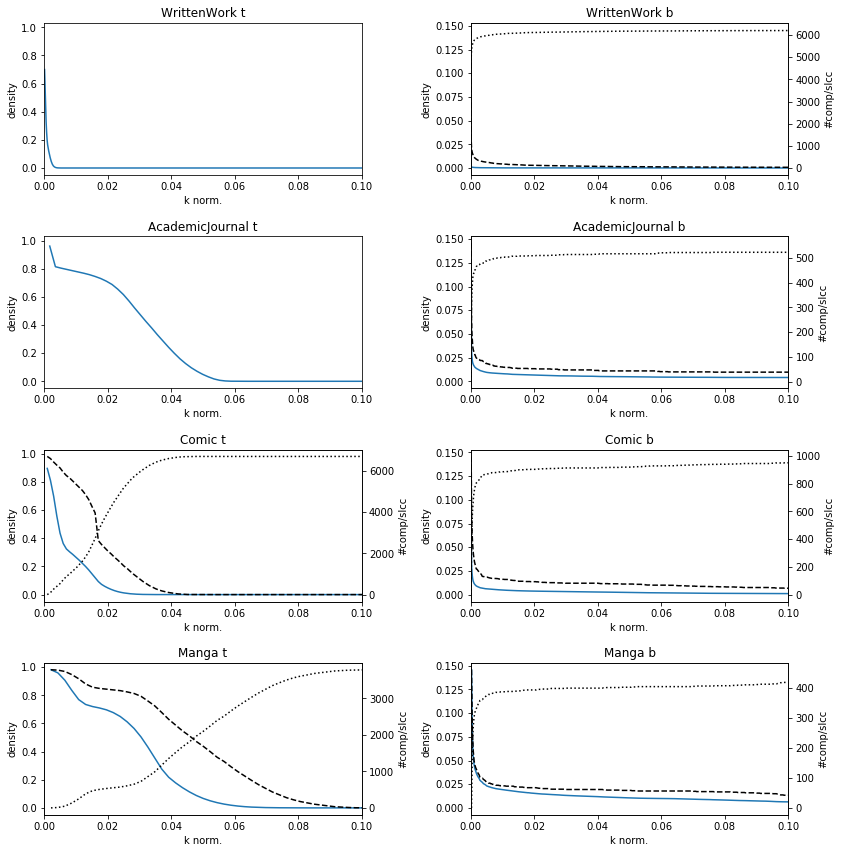

In [3]:
# KNC plots for each superclass and its subclasses

res = res_glob
# Control which classes to analyze. Add or remove rows in res DataFrame
classes = list(res.index.values)

pd.options.display.float_format = '{:,.4f}'.format
display(res[["m_t", "m_b", "dens_t", "dens_b", "k_0_t", "k_0_b", "rc_dens_t", "rc_dens_b", "rel_rc_t", "rel_rc_b", "superclass"]])

fig, axes = plt.subplots(len(classes), 2, sharex="none", sharey="col", figsize=(12, 3 * len(classes)))

# k_0_t_norm = (res["k_0_t"] / res["n_b"]).max() # Dynamic xmax (Can be very high with small density)
# print("k_0_t_norm", k_0_t_norm)

for classname in classes:
    row = classes.index(classname)
    try:
        df_t = pd.read_csv(f"out/{classname}/{classname}.t.knc.csv")
        df_b = pd.read_csv(f"out/{classname}/{classname}.b.knc.csv")
    except FileNotFoundError as e:
        print(classname, e)
    n_t = res.loc[classname, "n_t"]
    n_b = res.loc[classname, "n_b"]
        
    # Top
    k = []
    dens = []
    ncomp = []
    slcc = []
    has_ncomp = False
    has_slcc = False
    if "ncomponents" in df_t.columns:
        has_ncomp = True
    if "slcc" in df_t.columns:
        has_slcc = True

    for i, knc_row in df_t.iterrows():
        k.append(knc_row["k"] / n_b)
        dens.append(knc_row["density"])
        if has_ncomp:
            ncomp.append(knc_row["ncomponents"])
        if has_slcc:
            slcc.append(knc_row["slcc"])

    axes[row, 0].set_title(classname + " t")
    axes[row, 0].set_xlabel("k norm.")
    axes[row, 0].set_ylabel("density")
    axes[row, 0].plot(k, dens)
    axes[row, 0].set_xlim(0, 0.1)

    if has_ncomp and has_slcc:
        ax2 = axes[row, 0].twinx()
        ax2.plot(k, ncomp, color="black", linestyle="dotted")
        ax2.plot(k, slcc, color="black", linestyle="dashed")
        ax2.set_ylabel("#comp/slcc")
    # Bot
    k = []
    dens = []
    ncomp = []
    slcc = []
    has_ncomp = False
    has_slcc = False
    if "ncomponents" in df_b.columns:
        has_ncomp = True
    if "slcc" in df_b.columns:
        has_slcc = True

    for i, knc_row in df_b.iterrows():
        k.append(knc_row["k"] / n_t)
        dens.append(knc_row["density"])
        if has_ncomp:
            ncomp.append(knc_row["ncomponents"])
        if has_slcc:
            slcc.append(knc_row["slcc"])

    axes[row, 1].set_title(classname + " b")
    axes[row, 1].set_xlabel("k norm.")
    axes[row, 1].set_ylabel("density")
    axes[row, 1].plot(k, dens)
    axes[row, 1].set_xlim(0, 0.1)

    if has_ncomp and has_slcc:
        ax2 = axes[row, 1].twinx()
        ax2.plot(k, ncomp, color="black", linestyle="dotted")
        ax2.plot(k, slcc, color="black", linestyle="dashed")
        ax2.set_ylabel("#comp/slcc")

plt.subplots_adjust(wspace=50, hspace=10)
plt.tight_layout()

,n_t,n_b,ndisc_t,ndisc_b,k_t_g,k_b_g,k_mean_t,k_sd_t,k_mean_b,k_sd_b,k_med_t,k_med_b,superclass
WrittenWork,"90,862.00","6,235.00",4.00,0.00,15.74,229.43,"63,569.34","22,721.51",92.95,197.64,"73,262.00",40.00,Work
AcademicJournal,"7,688.00",561.00,1.00,1.00,22.74,311.62,"7,387.35",923.50,47.39,60.73,"7,558.00",27.00,PeriodicalLiterature
Comic,"6,688.00",996.00,0.00,0.00,18.46,123.96,"5,996.15","1,176.29",48.99,75.44,"6,347.00",29.00,WrittenWork
Manga,"3,783.00",459.00,0.00,0.00,21.42,176.55,"3,712.90",265.21,64.58,73.02,"3,753.00",40.00,Comic


Compare relative values e.g. (k_mean_t / n_t) ?


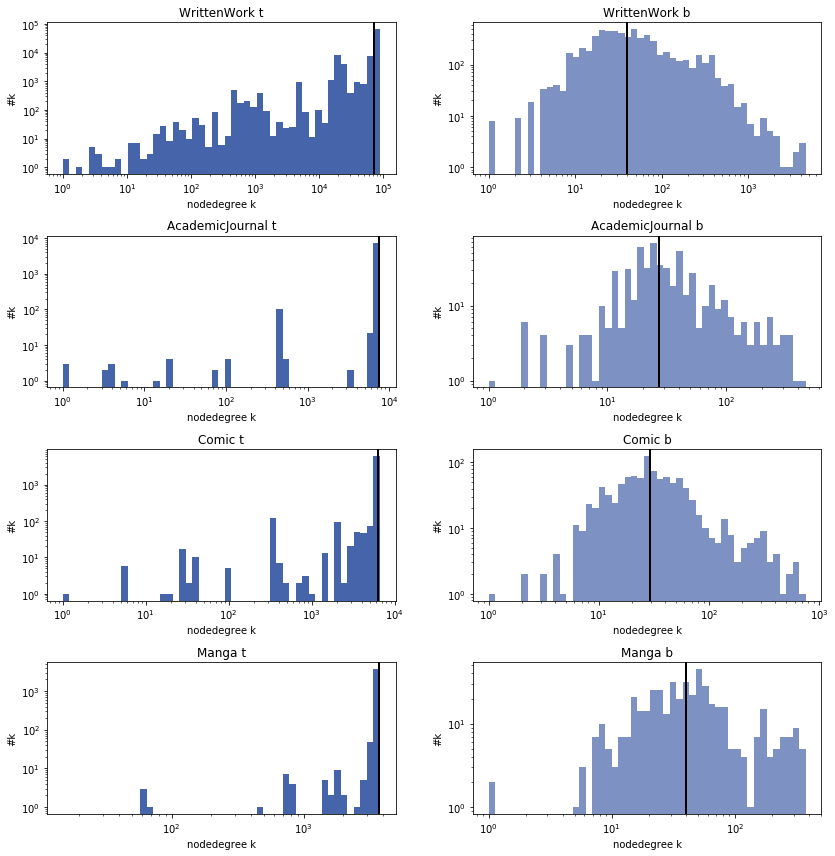

In [4]:
# Degree histogram of top and bot onemode graphs (log log scale)
# Wikidata degrees are most times 100% @ one k

res = res_glob
# Control which classes to analyze. Add or remove rows in res DataFrame
classes = list(res.index.values)
nrows = len(classes)
fig, axes = plt.subplots(nrows=nrows, ncols=2, sharex="none", sharey="none", figsize=(12, 3 * nrows))
for classname in classes:
    row = classes.index(classname)
    # Top
    with open(f"out/{classname}/{classname}.t.k.json", "r") as input_file:
        dist = json.load(input_file)
    n_t = res.loc[classname, "n_t"]
    k = []
    for degree, count in dist.items():
        k.extend([int(degree)] * count)

    logbins = np.geomspace(min(k), max(k), 50) # geomspace cannot include 0 (disc nodes)
    axes[row, 0].set_xscale("log")
    axes[row, 0].set_yscale("log")
    axes[row, 0].set_title(classname + " t")
    axes[row, 0].axvline(np.median(k), color='k', linewidth=2)
    axes[row, 0].set_xlabel("nodedegree k")
    axes[row, 0].set_ylabel("#k")
    # min_ylim, max_ylim = axes[row, 0].get_ylim()
    # axes[row, 0].text(np.median(k) * 1.1, max_ylim * 0.9, 'Mean: {:.2f}'.format(np.median(k))) # Draw median value
    hist, bins, _ = axes[row, 0].hist(k, bins=logbins, color=kit_blue_1)
    # Bot
    with open(f"out/{classname}/{classname}.b.k.json", "r") as input_file:
        dist = json.load(input_file)
    n_b = res.loc[classname, "n_b"]
    k = []
    for degree, count in dist.items():
        k.extend([int(degree)] * count)

    logbins = np.geomspace(min(k), max(k), 50)
    axes[row, 1].set_xscale("log")
    axes[row, 1].set_yscale("log")
    axes[row, 1].set_title(classname + " b")
    axes[row, 1].axvline(np.median(k), color='k', linewidth=2)
    axes[row, 1].set_xlabel("nodedegree k")
    axes[row, 1].set_ylabel("#k")
    hist, bins, _ = axes[row, 1].hist(k, bins=logbins, color=kit_blue_2)

pd.options.display.float_format = '{:,.2f}'.format
display(res[["n_t", "n_b", "ndisc_t", "ndisc_b", "k_t_g", "k_b_g", "k_mean_t", "k_sd_t", "k_mean_b", "k_sd_b", "k_med_t", "k_med_b", "superclass"]])
print("Compare relative values e.g. (k_mean_t / n_t) ?")
# TODO: Get list of subject nodes (with their predicates) of groups with abnormal low k
# TODO: Get list of normal subjects as example
# TODO: Get list of predicate nodes with abnormal low or high k

plt.subplots_adjust(wspace=10, hspace=10)
plt.tight_layout()

,m_t,m_b,w_med_t,w_med_b,superclass
WrittenWork,"2,887,891,628","289,775",3,1,Work
AcademicJournal,"28,393,284","13,269",16,1,PeriodicalLiterature
Comic,"20,051,129","24,399",4,1,WrittenWork
Manga,"7,022,957","14,820",14,2,Comic


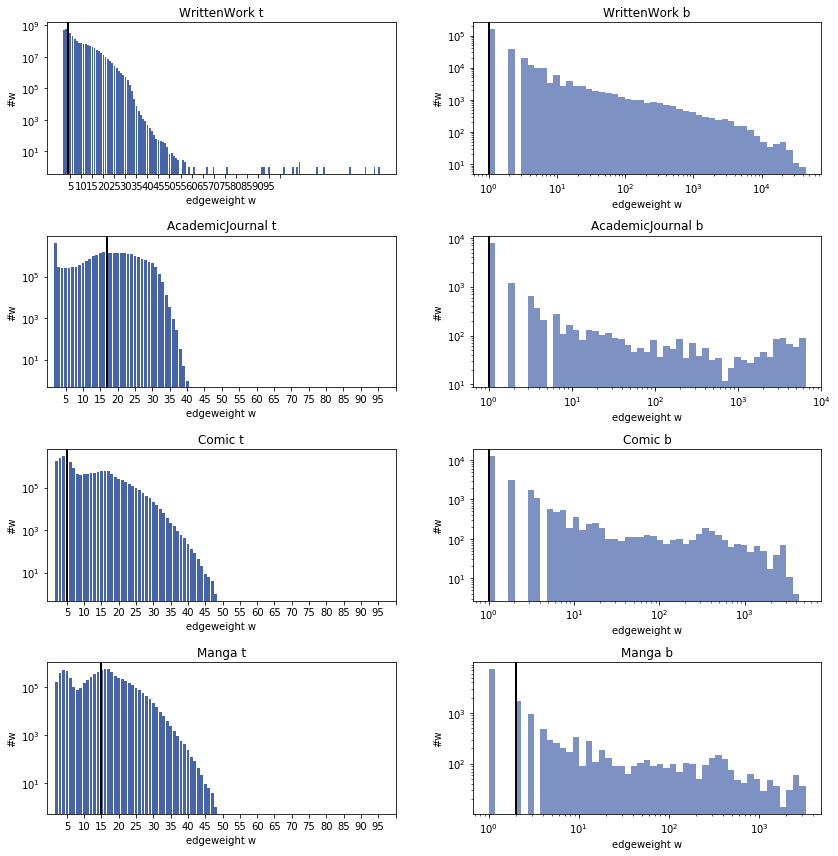

In [5]:
# Weight hist top and bot
# Difficulty: m_t very large, manual for t
# How to limit x axis?

res = res_glob
# Control which classes to analyze. Add or remove rows in res DataFrame
classes = list(res.index.values)

pd.options.display.float_format = '{:,.0f}'.format
display(res[["m_t", "m_b", "w_med_t", "w_med_b", "superclass"]]) # TODO: sdev

fig, axes = plt.subplots(nrows=len(classes), ncols=2, sharex="none", sharey="none", figsize=(12, 3 * len(classes)))
for classname in classes:
    row = classes.index(classname)
    # Top (density dist)
    w = []
    pw = []
    with open(f"out/{classname}/{classname}.t.w.json", "r") as input_file:
        dist = json.load(input_file)
    median = res.loc[classname, "w_med_t"]
    for weight, count in dist.items():
        if int(weight) > 0:
            w.append(int(weight))
            pw.append(count)
    axes[row, 0].bar(w, pw, align='center', color=kit_blue_1)
    axes[row, 0].axvline(median, color='k', linewidth=2)
    axes[row, 0].set_title(classname + " t")
    axes[row, 0].set_yscale("log")
    axes[row, 0].tick_params(axis="x", reset=True, top=False)
    axes[row, 0].set_xticks(range(4, 100, 5))
    axes[row, 0].set_xticklabels(range(5, 100, 5))
    axes[row, 0].set_xlabel("edgeweight w")
    axes[row, 0].set_ylabel("#w")
    # Bot (hist)
    w = []
    with open(f"out/{classname}/{classname}.b.w.json", "r") as input_file:
        dist = json.load(input_file)
    for weight, count in dist.items():
        if int(weight) > 0:
            w.extend([int(weight)] * count)
    
    logbins = np.geomspace(min(w), max(w), 50)
    axes[row, 1].set_xscale("log")
    axes[row, 1].set_yscale("log")
    axes[row, 1].set_title(classname + " b")
    axes[row, 1].set_xlabel("edgeweight w")
    axes[row, 1].set_ylabel("#w")
    axes[row, 1].axvline(np.median(w), color='k', linewidth=2)
    hist, bins, _ = axes[row, 1].hist(w, bins=logbins, color=kit_blue_2)

# TODO: Get list of subject pairs with high w and low w
# TODO: Get list of predicate pairs with high w and low w

plt.subplots_adjust(wspace=10, hspace=10)
plt.tight_layout()

,n_t,n_b,k_t_g,k_b_g,c_mean_t,c_sd_t,c_mean_b,c_sd_b,c_med_t,c_med_b,superclass
WrittenWork,"90,862.00","6,235.00",15.74,229.43,"310,860.44","205,948.56","4,633.74","40,442.02","305,451.50",63.00,Work
AcademicJournal,"7,688.00",561.00,22.74,311.62,"112,203.53","44,751.07","7,932.95","30,371.82","127,212.00",29.50,PeriodicalLiterature
Comic,"6,688.00",996.00,18.46,123.96,"43,254.63","21,863.40","2,503.84","11,104.10","42,269.00",46.50,WrittenWork
Manga,"3,783.00",459.00,21.42,176.55,"46,751.83","17,363.77","4,444.51","14,158.64","51,004.00",53.00,Comic


Compare relative values e.g. (k_mean_t / n_t) ?


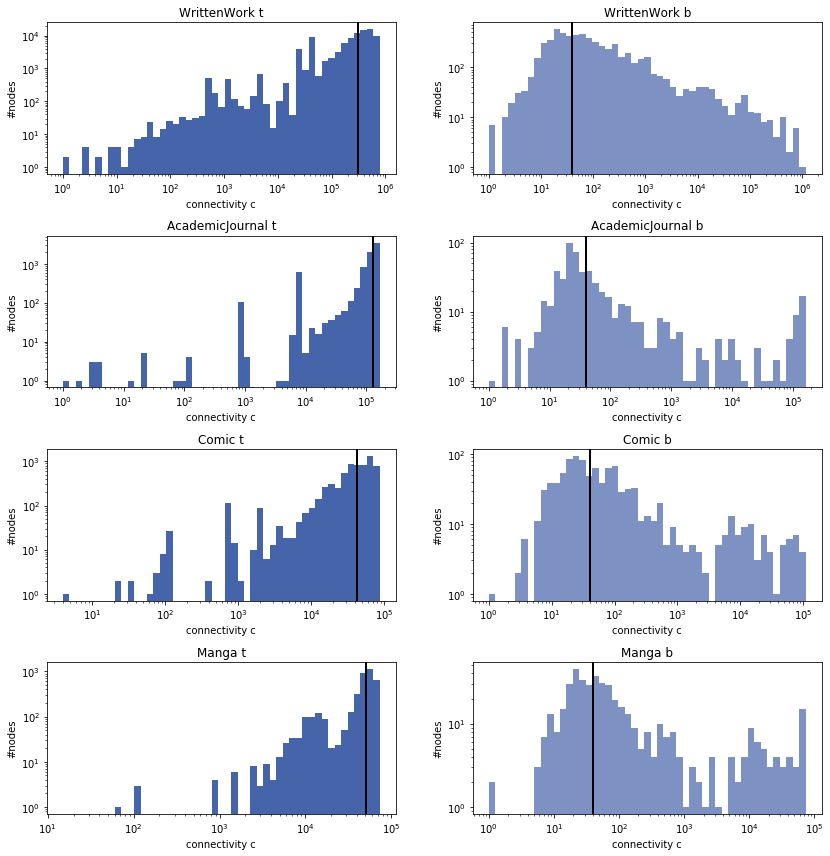

In [6]:
# Connectivity histogram of top and bot onemode graphs

res = res_glob
# Control which classes to analyze. Add or remove rows in res DataFrame
classes = list(res.index.values)

pd.options.display.float_format = '{:,.2f}'.format
display(res[["n_t", "n_b", "k_t_g", "k_b_g", "c_mean_t", "c_sd_t", "c_mean_b", "c_sd_b", "c_med_t", "c_med_b", "superclass"]])
print("Compare relative values e.g. (k_mean_t / n_t) ?")

nrows = len(classes)
fig, axes = plt.subplots(nrows=nrows, ncols=2, sharex="none", sharey="none", figsize=(12, 3 * nrows))
for classname in classes:
    row = classes.index(classname)
    # Top
    with open(f"out/{classname}/{classname}.t.c.json", "r") as input_file:
        dist = json.load(input_file)
    c = []
    for connectivity, count in dist.items():
        c.extend([int(connectivity)] * count)

    logbins = np.geomspace(min(c), max(c), 50) # geomspace cannot include 0 (disc nodes)
    axes[row, 0].set_xscale("log")
    axes[row, 0].set_yscale("log")
    axes[row, 0].set_title(classname + " t")
    axes[row, 0].axvline(np.median(c), color='k', linewidth=2)
    axes[row, 0].set_xlabel("connectivity c")
    axes[row, 0].set_ylabel("#nodes")
    # min_ylim, max_ylim = axes[row, 0].get_ylim()
    # axes[row, 0].text(np.median(k) * 1.1, max_ylim * 0.9, 'Mean: {:.2f}'.format(np.median(k))) # Draw median value
    hist, bins, _ = axes[row, 0].hist(c, bins=logbins, color=kit_blue_1)
    # Bot
    with open(f"out/{classname}/{classname}.b.c.json", "r") as input_file:
        dist = json.load(input_file)
    c = []
    for connectivity, count in dist.items():
        c.extend([int(connectivity) for i in range(0, count)])

    logbins = np.geomspace(min(c), max(c), 50)
    axes[row, 1].set_xscale("log")
    axes[row, 1].set_yscale("log")
    axes[row, 1].set_title(classname + " b")
    axes[row, 1].axvline(np.median(k), color='k', linewidth=2)
    axes[row, 1].set_xlabel("connectivity c")
    axes[row, 1].set_ylabel("#nodes")
    hist, bins, _ = axes[row, 1].hist(c, bins=logbins, color=kit_blue_2)

plt.subplots_adjust(wspace=10, hspace=10)
plt.tight_layout()

n_t_super 90862.0
n_b_super 6235.0
n_b_th WrittenWork 6.0
n_b_th AcademicJournal 11.0
n_b_th Comic 11.0
n_b_th Manga 12.0


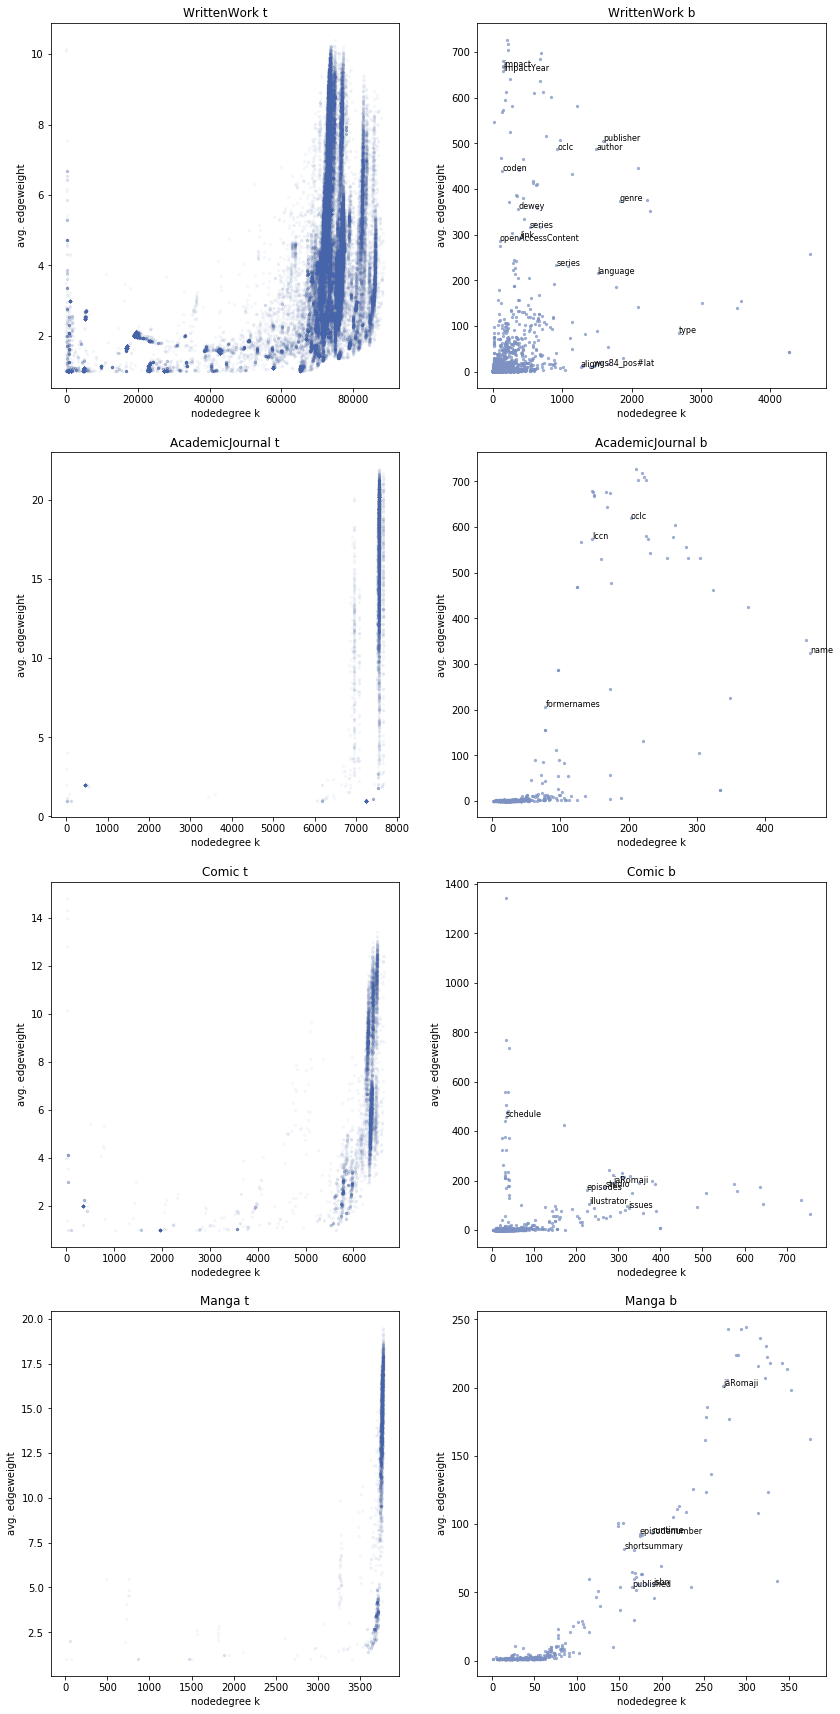

In [7]:
# Average edge weight (connectivity based) over degree per entity scatterplot

res = res_glob
# Control which classes to analyze. Add or remove rows in res DataFrame
classes = list(res.index.values)

nrows = len(classes)
fig, axes = plt.subplots(nrows=nrows, ncols=2, sharex="none", sharey="none", figsize=(12, nrows*6))
n_t_super = res["n_t"].iloc[0]
n_b_super = res["n_b"].iloc[0]
print("n_t_super", n_t_super)
print("n_b_super", n_b_super)
for classname in classes:
    row = classes.index(classname)
    # Top
    n = []
    k = []
    c = []
    with open(f"out/{classname}/{classname}.t.nk.json", "r") as input_file:
        nk_dist = json.load(input_file)
    with open(f"out/{classname}/{classname}.t.nc.json", "r") as input_file:
        nc_dist = json.load(input_file)

    for key, value in nk_dist.items():
        n.append(key.split('/')[-1][:9])
        k.append(value)
        c.append(nc_dist.get(key) / value)

    axes[row, 0].set_title(classname + " t")
    axes[row, 0].set_xlabel("nodedegree k")
    axes[row, 0].set_ylabel("avg. edgeweight")
    axes[row, 0].scatter(k, c, s=5, color=kit_blue_1+"0a")
    # n_t = res.loc[classname, "n_t"]
    # n_t_th = round(np.interp(n_t, [0, n_t_super], [100, 600]))
    # print(f"n_t_th {classname} {n_t_th}")
    # for i, label in enumerate(n): # Only annotate some entities
    #     if (round(c[i]) % 2 == 0 and i % n_t_th == 0):
    #         axes[row, 1].annotate(label, (k[i], c[i]), fontsize=8)
    # Bot
    n = []
    k = []
    c = []
    with open(f"out/{classname}/{classname}.b.nk.json", "r") as input_file:
        nk_dist = json.load(input_file)
    with open(f"out/{classname}/{classname}.b.nc.json", "r") as input_file:
        nc_dist = json.load(input_file)

    for key, value in nk_dist.items():
        n.append(key.split('/')[-1])
        k.append(value)
        c.append(nc_dist.get(key) / value)
    
    axes[row, 1].set_title(classname + " b")
    axes[row, 1].set_xlabel("nodedegree k")
    axes[row, 1].set_ylabel("avg. edgeweight")
    axes[row, 1].scatter(k, c, s=5, color=kit_blue_2+"aa")
    n_b = res.loc[classname, "n_b"]
    n_b_th = round(np.interp(n_b, [0, n_b_super], [12, 6]))
    print(f"n_b_th {classname} {n_b_th}")
    for i, label in enumerate(n): # Annotate only some entities
        if ((k[i] > (axes[row, 1].get_xlim()[1] * 0.25) and i % n_b_th == 0)
            or (c[i] > (axes[row, 1].get_ylim()[1] * 0.25) and i % n_b_th == 0)):
            axes[row, 1].annotate(label, (k[i], c[i]), fontsize=8)

# TODO: Get subject and predicate examples from nc (typical from cluster, and atypical manually queried)

plt.subplots_adjust(wspace=10, hspace=10)
plt.tight_layout()

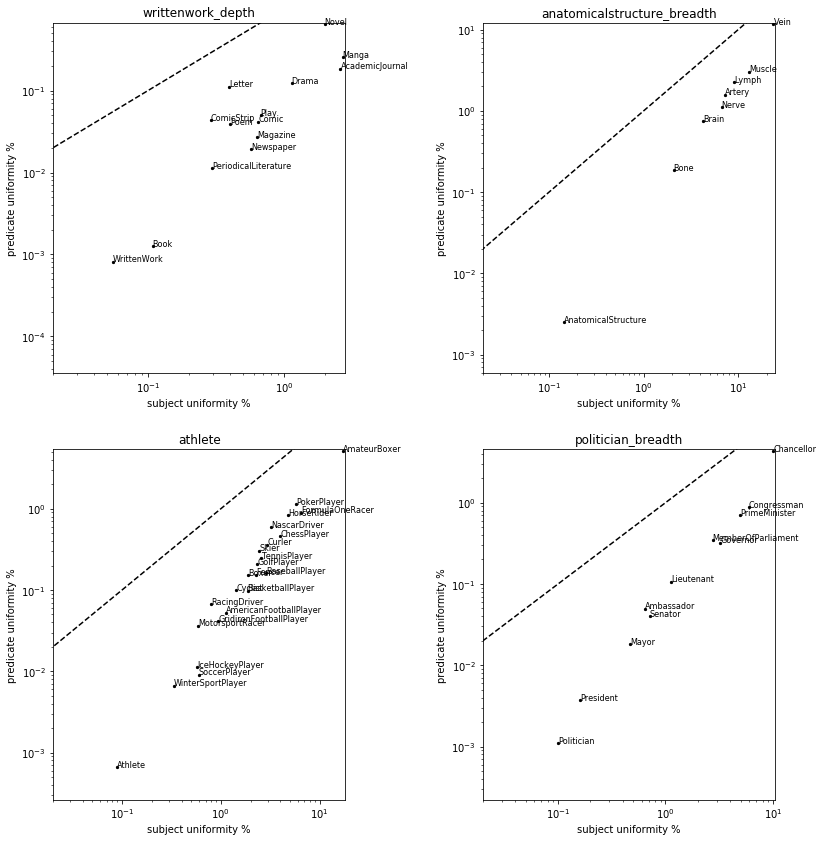

In [10]:
# rc_t over rc_b (in %) for each class and each run scatterplot
runs = [
    "writtenwork_depth",
    "anatomicalstructure_breadth",
    "athlete",
    "politician_breadth",
]

nrows = math.ceil(len(runs) / 2)
fig, axes = plt.subplots(nrows=nrows, ncols=2, sharex="none", sharey="none", figsize=(12, nrows*6))
for run in runs:
    label = []
    sclass = []
    subj = []
    pred = []
    res = pd.read_csv(f"out/_results_{run}.csv", index_col=0)
    for classname in res.index.values:
        label.append(classname)
        sclass.append(res.loc[classname, "superclass"])
        subj.append(res.loc[classname, "rc_dens_t"] * 100)
        pred.append(res.loc[classname, "rc_dens_b"] * 100)

    runnr = runs.index(run)
    row = math.floor(runnr / 2)
    col = runnr % 2
    axes[row, col].set_title(run)
    axes[row, col].set_xlabel("subject uniformity %")
    axes[row, col].set_ylabel("predicate uniformity %")
    axes[row, col].scatter(subj, pred, marker="o", s=5, color="black")
    for i, label in enumerate(label):
        axes[row, col].annotate(label, (subj[i], pred[i]), fontsize=8)

    xmin, xmax = axes[row, col].get_xlim()
    ymin, ymax = axes[row, col].get_ylim()
    axes[row, col].set_xlim(0.02, xmax)
    axes[row, col].set_ylim(ymin - (ymin * 1.001), ymax)

    axes[row, col].set_xscale("log")
    axes[row, col].set_yscale("log")

    axes[row, col].autoscale(False)

    origin_x = np.linspace(0.001,100,3)
    origin_y = origin_x
    axes[row, col].plot(origin_x, origin_y, color="black", linestyle="dashed")

plt.subplots_adjust(wspace=10, hspace=10)
plt.tight_layout()

n_t 5, n_b 4, m 10


/home/david/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


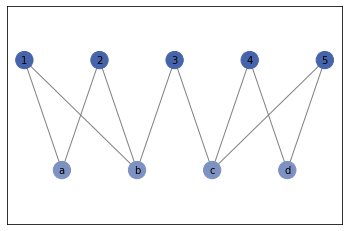

In [11]:
# Example bipartite graphs
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4, 5], bipartite=0)
G.add_nodes_from(["a", "b", "c", "d"], bipartite=1)
# Full connected graph
# G.add_edges_from([(1,"a"),(1,"b"),(1,"c"),(1,"d"),
#                     (2,"a"),(2,"b"),(2,"c"),(2,"d"),
#                     (3,"a"),(3,"b"),(3,"c"),(3,"d"),
#                     (4,"a"),(4,"b"),(4,"c"),(4,"d"),
#                     (5,"a"),(5,"b"),(5,"c"),(5,"d")])
# FiveFour graph
# G.add_edges_from([(1,"a"),(1,"b"),(1,"c"),
#                     (2,"a"),(2,"b"),(2,"c"),
#                     (3,"a"),(3,"b"),(3,"c"),(3,"d"),
#                     (4,"b"),(4,"c"),
#                     (5,"d")])
# Disconnected graph
# G.add_edges_from([(1,"a"),
#                     (2,"b"),
#                     (3,"c"),
#                     (4,"d")])
# 2 Cluster graph
G.add_edges_from([(1,"a"),(1,"b"),
                    (2,"a"),(2,"b"),
                    (3,"b"),(3,"c"),
                    (4,"c"),(4,"d"),
                    (5,"c"),(5,"d")])
top = [1, 2, 3, 4, 5] # top, bot = nx.bipartite.sets(G)
bot = ["a", "b", "c", "d"]
color_dict = {0: kit_blue_1, 1: kit_blue_2}
color_list = [color_dict[i[1]] for i in G.nodes.data("bipartite")]
print(f"n_t {len(top)}, n_b {len(bot)}, m {G.number_of_edges()}")

# bi_layout = nx.bipartite_layout(G, top, align="horizontal", aspect_ratio=20, scale=1)
# nx.draw_networkx(G, bi_layout, font_size=10, edge_color="grey", node_color=color_list)

bot_len = len(bot)
pos = dict()
pos.update((n, (i, 1.1)) for i, n in enumerate(top))
pos.update((n, (i + 0.5, 1)) for i, n in enumerate(bot))
nx.draw_networkx(G, pos=pos, font_size=10, edge_color="grey", node_color=color_list)

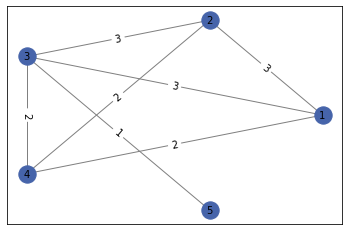

In [12]:
# Example onemode graphs
G = nx.Graph()
# Top mode
# FiveFour graph
G.add_nodes_from([1, 2, 3, 4, 5])
G.add_weighted_edges_from([(1,2,3),(1,3,3),(1,4,2),
                            (2,3,3),(2,4,2),
                            (3,4,2),(3,5,1)])

nx.draw_networkx(G, pos=nx.circular_layout(G, scale=1), font_size=10, edge_color="grey", node_color=kit_blue_1)
labels = nx.get_edge_attributes(G, 'weight')
_ = nx.draw_networkx_edge_labels(G, pos=nx.circular_layout(G, scale=1), edge_labels=labels, font_size=10)

# Full connected graph
# G.add_edges_from([(1,"a"),(1,"b"),(1,"c"),(1,"d"),
#                     (2,"a"),(2,"b"),(2,"c"),(2,"d"),
#                     (3,"a"),(3,"b"),(3,"c"),(3,"d"),
#                     (4,"a"),(4,"b"),(4,"c"),(4,"d"),
#                     (5,"a"),(5,"b"),(5,"c"),(5,"d")])

# Disconnected graph
# G.add_edges_from([(1,"a"),
#                     (2,"b"),
#                     (3,"c"),
#                     (4,"d")])
# 2 Cluster graph
# G.add_edges_from([(1,"a"),(1,"b"),
#                     (2,"a"),(2,"b"),
#                     (3,"b"),(3,"c"),
#                     (4,"c"),(4,"d"),
#                     (5,"c"),(5,"d")])

# G.add_nodes_from(["a", "b", "c", "d"])